In [1]:
import numpy as np

In [2]:
def runge_kutta_FHN_network(ini, control, tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A): 

    x=np.zeros((tsteps,d,N))
    x[0]=ini    
    for ts in np.arange(0,tsteps-1):
        k1 = dt* ODE_FHN_network(x[ts],ts,control,tsteps , d , dt , N , alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k2 = dt* ODE_FHN_network(x[ts] + k1/2 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k3 = dt* ODE_FHN_network(x[ts] + k2/2 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)
        k4 = dt* ODE_FHN_network(x[ts] + k3 , ts ,control,tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu, sigma, A)
        x[ts+1]= x[ts] + (1/6)* (k1 + 2*k2 + 2*k3 + k4)
    return x

def ODE_FHN_network(x,ts,control, tsteps , d, dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A):

    out=np.zeros(x.shape)
    control=control.reshape(tsteps,N)
    Coupling = np.dot(A,x[0])
    out[0]= R(x[0], alpha , beta, gamma) - x[1] + mu + control[ts] + sigma * Coupling
    out[1]= (1/tau)* (x[0] + delta  - epsilon* x[1])
    return out  

def R(x, alpha , beta, gamma):

    return -alpha* x**3 + beta *x**2 - gamma* x 

In [3]:
def set_parameters(goal,bifurcation, A):
    """Set all needed node and network parameters

        Parameters
        ----------
        goal : string, can be 'sync' or 'switch'
            the control task
        bifurcation : string, can be 'low' or 'high'
            bifurcation lne close to which parameters are chosen
        filedir : string
            directory of file in which the code and the folder data lie

        Returns
        -------
        parameters: dictionary
            dictionary with all needed node and network parameters
    """
    #single node parameters
    parameters={
        'alpha':3.0,
        'beta':4.0,
        'gamma':3./2,
        'delta':0,
        'epsilon':0.5,
        'tau':20.0
    }
    #position in state space
    if goal=='sync':
        parameters['sigma']=0.025
        if bifurcation=='low':
            parameters['mu']=0.7
        elif bifurcation=='high':
            parameters['mu']=1.3
    if goal=='switch':
        if bifurcation=='low':
            parameters['mu']=0.378
            parameters['sigma']=0.21
        elif bifurcation=='high':
            parameters['mu']=1.22
            parameters['sigma']=0.26

    #adjacency matrix
    parameters['A'] = A
    parameters['N'] = A.shape[0] #number of nodes

    return parameters

In [4]:
def read_node_inis_from_file(node_ic,switchfromto,tsteps,d,dt,parameters):
    """Load file with predefines initial conditions for all nodes

        Parameters
        ----------
        bifurcation : string, can be 'low' or 'high'
            bifurcation lne close to which parameters are chosen
        switchfromto : string, can be 'lowtohigh' or 'hightolow'
            low to high means that the low state is the initial state and the high state the target state and vice versa
        filedir : string
            direction of file in which the code and the folder data lie
        tstaps : int
            number of time integration steps
        d : int
            dimension of an uncoupled node (d=2 for FHN)
        dt : time integration stepsize
            strenght f the Gaussian normalized white noise
        parameters : dictionary
            includes all node and netwrok parameters

        Returns
        -------
        node_ic: array of shape (d,N)
            initial conditions for all nodes
        target_state: array of shape (tsteps,N)
            the state we want to achieve with the control
    """
    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']
    control=np.zeros((tsteps,N))

    if switchfromto=='lowtohigh':
        #node_ic=ic_state_low
        target_state=runge_kutta_FHN_network(node_ic, control,  tsteps , d , dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)[:,0,:]
    elif switchfromto=='hightolow':
        #node_ic=ic_state_high
        target_state=runge_kutta_FHN_network(node_ic, control ,  tsteps , d , dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)[:,0,:]
    return target_state        

In [5]:
#This is an minimal example for the calculation of an optimal control input 
#to a coupled network of FitzHugh-Nagumo oscillators. In this example the control 
#task is to switch between predefined bistable states. For more precise documentationa 
#and for altering parameters please use the jupyter notebook file example.ibynb!

#The calculation of this example might take a few minutes.

#!/usr/bin/env python
# coding: utf-8

import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm

goal='switch'
bifurcation='low'
switchfromto='lowtohigh' 
noise_strength= 0.0 
realizations=1
noise=0
A = np.zeros((2,))
parameters = set_parameters(goal,bifurcation,A) 


In [30]:
#Set dimensions
T= 300 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set parameters of the cost functional
I_p_in= 0.0005
I_p=np.zeros((tsteps,parameters['N']))
I_p[int(tsteps-25/dt):]=I_p_in*np.ones((int(25/dt),parameters['N']))
I_e= 1.0 
I_s= 0.0


#choose initial condition for control
control=-np.ones((tsteps,parameters['N']))*0.002
control=control.reshape(tsteps*parameters['N'])

#node_ic = np.ones((2,1))
low = np.zeros((2,1)) #np.array([[0.14],[0.29]])
node_ic = low
high = np.ones((2,1)) #np.array([[0.2],[0.58]])
target_output=read_node_inis_from_file(high,switchfromto,tsteps,d,dt,parameters)

#make dictionary with all parameters
args = {
    'tsteps':tsteps,
    'dt':dt,
    'd':d,
    'I_p':I_p,
    'I_e':I_e,
    'I_s':I_s,
    'target_output':target_output,
    'node_ic':node_ic,
    'realizations':realizations,
    'noise':noise
    }
args.update(parameters)

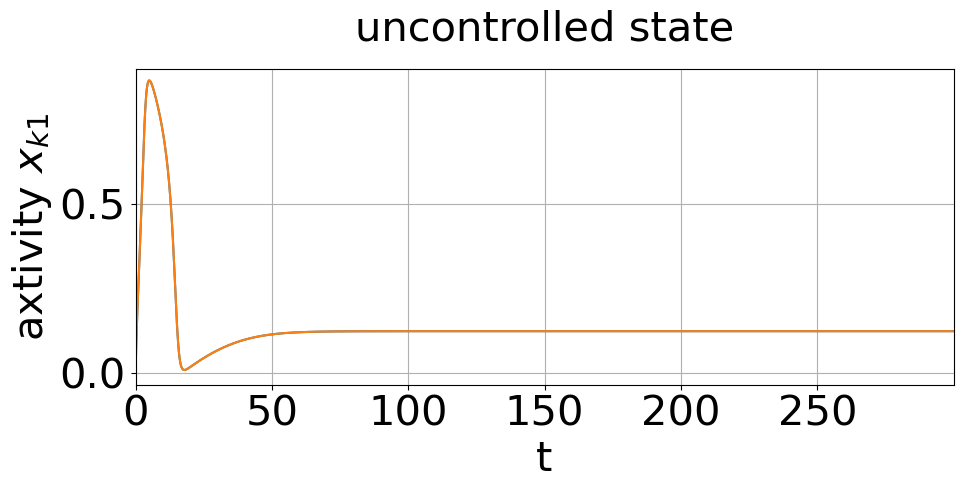

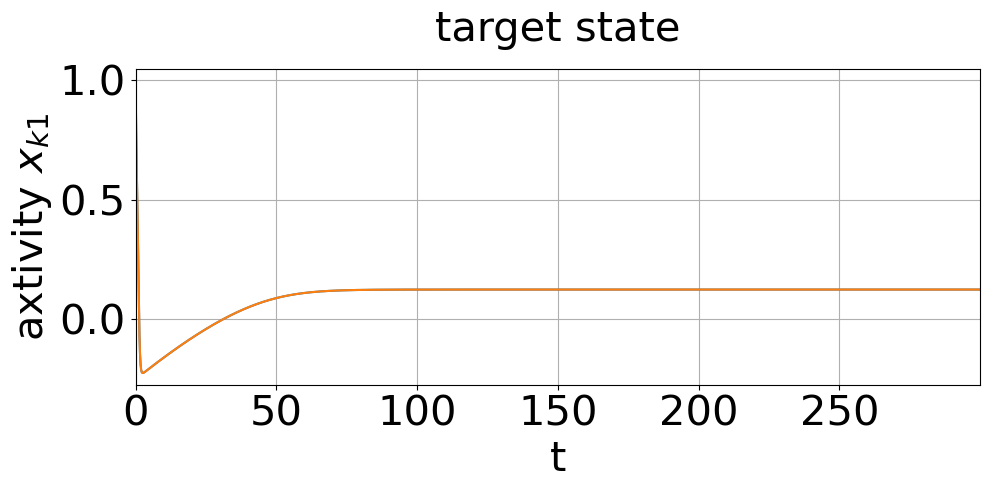

In [31]:
#In this case we want to find an optimal control that induces a switching 
#from an initial low state to a high target state. The uncontrolled state and 
#the target state are plotted:

def create_plot(data,ylabel,title):
    fs=30 #fontsize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))

    # set min and max for scope of y-axis
    minn=np.min(data)
    maxx=np.max(data)
    add=(maxx-minn)/25

    im1=ax.plot(np.arange(0,int(T),dt),data)
    ax.set_xlabel('t',size=fs)
    ax.set_ylabel(ylabel,size=fs)
    ax.set_ylim(minn-add,maxx+add)
    ax.set_title(title,size=fs, pad=20)
    ax.tick_params(labelsize=fs)
    ax.grid(True)
    ax.margins(0) # remove default margins (matplotlib verision 2+)

    return fig.tight_layout()

#calculate the uncontrolled state
nocontrol=np.zeros((tsteps,parameters['N']))
state_uncontrolled=functions.plot_runge_kutta(functions.ODE_FHN_network,nocontrol, **args)

create_plot(state_uncontrolled[:,0,:],'axtivity $x_{k1}$','uncontrolled state')
plt.show()
create_plot(target_output,'axtivity $x_{k1}$','target state')
plt.show()

In [32]:
#To find the optimal control we define the cost functional and its gradient and start the optimization loop.

#define the functional and its gradient
functional=functions.f_switch
gradient=functions.fprime_switch

#initialize the control loop
iteration=0 
#warnflag=1-> running, warnflag=0->finished, warnflag=3->error
warnflag=1
#start the optmization
result = FR_algorithm(functional, control, gradient,**args)
control=result[0]
warnflag=result[2]
iteration+=result[4]
print('Code finished after ',iteration,' iterations with warnflag',result[2])

gnorm 7.760893612080845e-05 uknorm 0.0002440049365509257
Code finished after  6  iterations with warnflag 0


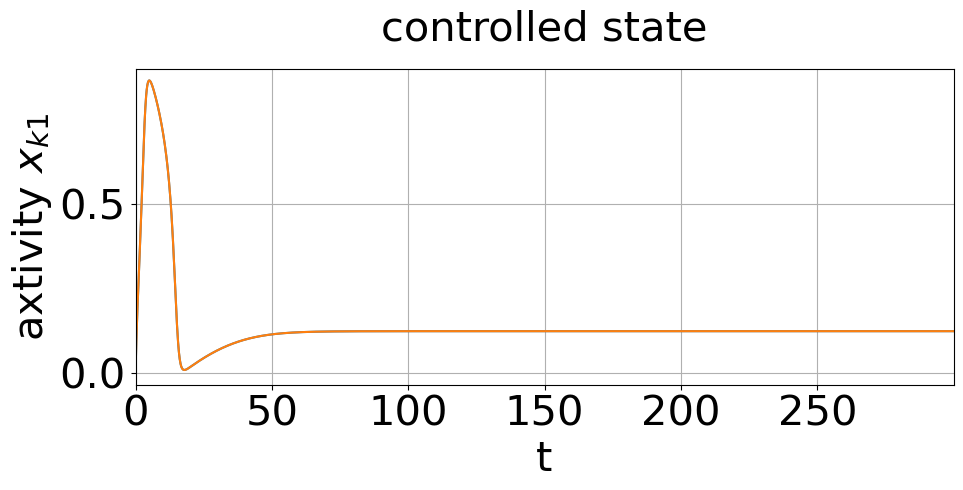

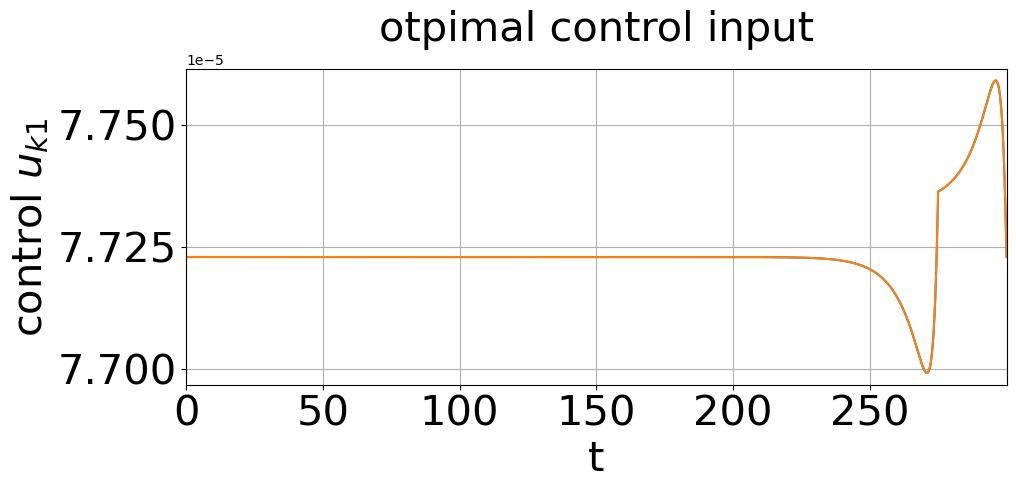

In [33]:
#The results can now be plottet:

#calculate the controlled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)

create_plot(state_controlled[:,0,:],'axtivity $x_{k1}$','controlled state')
plt.show()
create_plot(control,'control $u_{k1}$','otpimal control input')
plt.show()


In [10]:
zero_state = np.zeros((500,2))

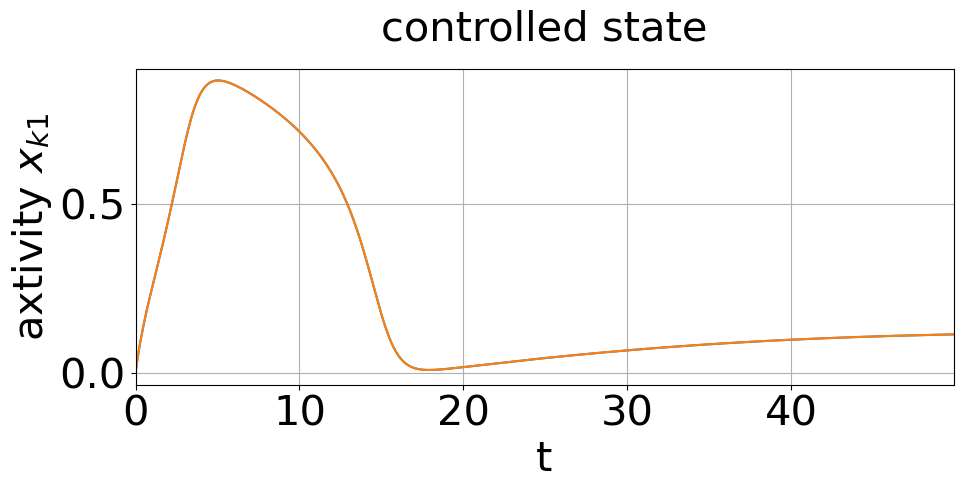

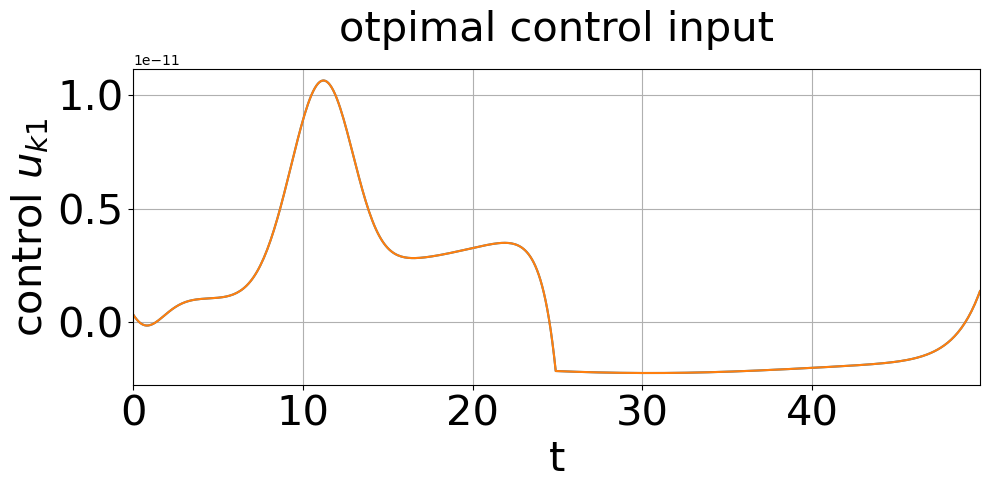

In [11]:
#The results can now be plottet:

#calculate the controlled state
control=control.reshape(tsteps,parameters['N'])
state_controlled=functions.plot_runge_kutta(functions.ODE_FHN_network,control, **args)

create_plot(state_controlled[:,0,:],'axtivity $x_{k1}$','controlled state')
plt.show()
create_plot(control,'control $u_{k1}$','otpimal control input')
plt.show()


In [13]:
import pykoopman as pk

In [105]:
state_controlled[:,0,:].shape

(500, 2)

In [106]:
EDMDc = pk.regression.EDMDc()
RBF = pk.observables.RadialBasisFunction(rbf_type='thinplate', n_centers=10, centers=None, kernel_width=1.0, polyharmonic_coeff=1.0, include_state=True)

model = pk.Koopman(observables=RBF, regressor=EDMDc)
model.fit(state_controlled[:,0,:], u=control)

/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/pykoopman/observables/_radial_basis_functions.py:180: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.measurement_matrix_ = np.linalg.lstsq(xlift, x)[0].T


Koopman(observables=RadialBasisFunction(centers=array([[0.40685412, 0.66520463, 0.        , 0.86660909, 0.39561094,
        0.83345874, 0.55767995, 0.65146696, 0.58432443, 0.02027345],
       [0.46967356, 0.86660909, 0.05222693, 0.3322532 , 0.32280042,
        0.06146889, 0.84237135, 0.62326241, 0.20751209, 0.        ]]),
                                        rbf_type='thinplate'),
        regressor=EDMDc())

In [112]:
Xkoop = model.simulate(state_controlled[np.newaxis,0,0,:], u=control, n_steps=500)

/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/pykoopman/observables/_radial_basis_functions.py:259: RuntimeWarning: overflow encountered in square
  r_squared = np.sum((x - C[np.newaxis, :]) ** 2, axis=1)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/pykoopman/regression/_edmdc.py:154: RuntimeWarning: invalid value encountered in matmul
  y = x @ self.state_matrix_.T + u @ self.control_matrix_.T


ValueError: Input contains NaN.

/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


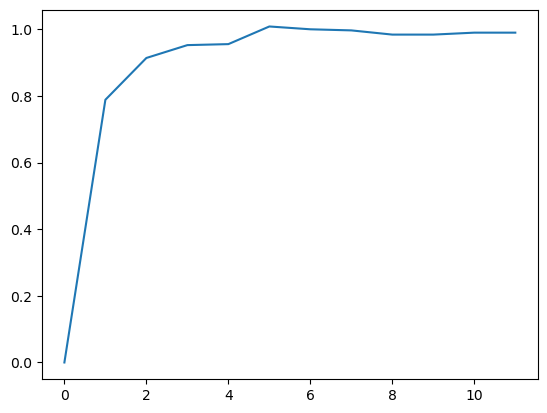

In [107]:
evals, evecs = np.linalg.eig(model.A)
plt.plot(evals)
plt.show()

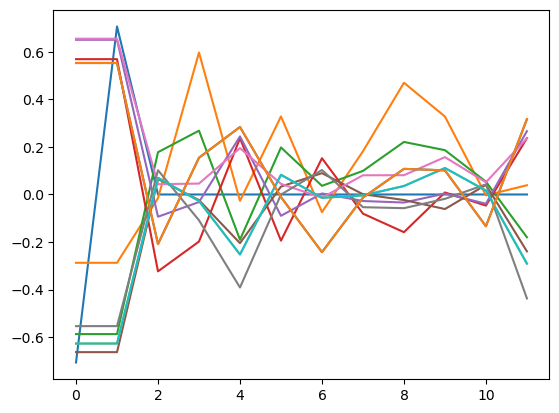

In [109]:
plt.plot(evecs)
plt.show()

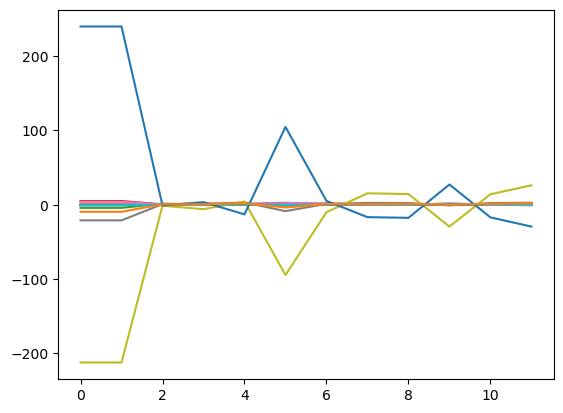

In [56]:
plt.plot(model.A)
plt.show()

Text(0.5, 1.0, 'L2 norm error = 10.788495585616268')

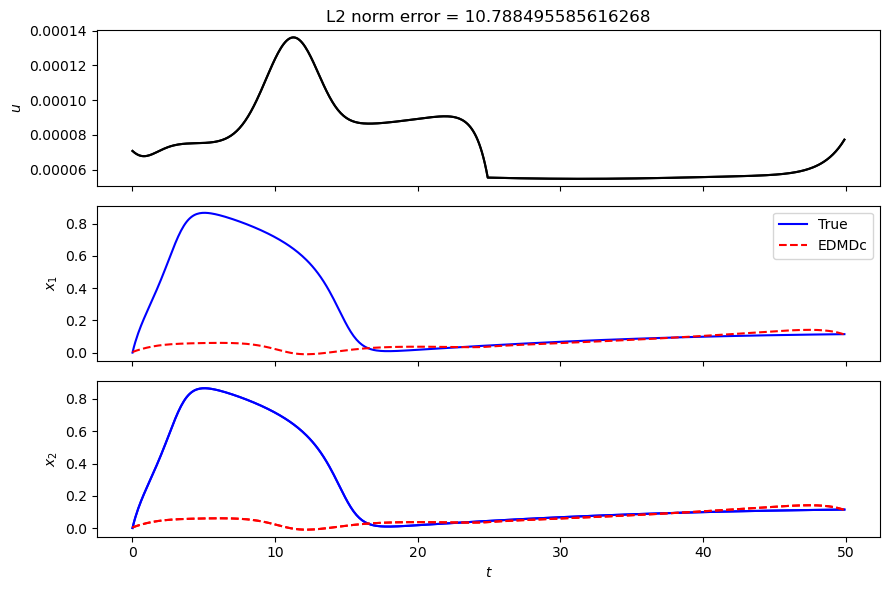

In [111]:
Xtrue = state_controlled[:,0,:]
t = np.arange(0, Xkoop.shape[0]*dt, dt)
u = control
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[:, 0], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue, '-', color='b', label='True')
axs[2].plot(t, Xkoop, '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop)
axs[0].set_title(f"L2 norm error = {err}")

Text(0.5, 1.0, 'L2 norm error = 10.787786329945142')

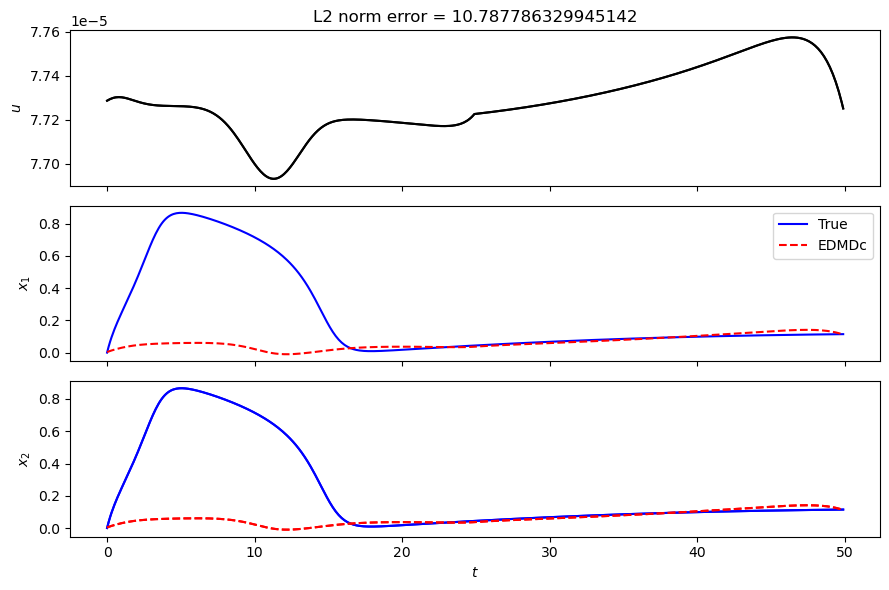

In [44]:
Xtrue = state_controlled[:,0,:]
t = np.arange(0, Xkoop.shape[0]*dt, dt)
u = control
fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(9, 6))
axs[0].plot(t, u, '-k')
axs[0].set(ylabel=r'$u$')
axs[1].plot(t, Xtrue[:, 0], '-', color='b', label='True')
axs[1].plot(t, Xkoop[:, 0], '--r', label='EDMDc')
axs[1].set(ylabel=r'$x_1$')
axs[2].plot(t, Xtrue, '-', color='b', label='True')
axs[2].plot(t, Xkoop, '--r', label='EDMDc')
axs[2].set(
        ylabel=r'$x_2$',
        xlabel=r'$t$')

axs[1].legend()

err = np.linalg.norm(Xtrue - Xkoop)
axs[0].set_title(f"L2 norm error = {err}")

In [126]:
from pydmd import DMD

dmd = DMD(svd_rank=5)
model = pk.Koopman(regressor=dmd)
model.fit(state_controlled[:,0,:], dt)

AttributeError: 'DMD' object has no attribute 'tlsq_rank'

In [14]:
regr = pk.regression.EDMD()
obsv = pk.observables.Polynomial(degree=3)
model_edmd = pk.Koopman(observables=obsv, regressor=regr)
model_edmd.fit(state_controlled[:,0,:], dt=dt)

/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)


Koopman(observables=Polynomial(degree=3), regressor=EDMD())

In [28]:
state_controlled[:,0,:].shape

(500, 2)

In [15]:
koop_eigenvals = np.log(np.linalg.eig(model_edmd.A)[0])/dt

print(f"koopman eigenvalues = {koop_eigenvals}")

koopman eigenvalues = [ 3.03584222e+02 +0.j          9.97212566e-01 +0.j
 -1.02438123e+00 +0.j         -1.75956927e-08 +0.j
  2.07452731e-03 +0.j         -2.55634959e+01+31.41592654j
 -3.05537504e+01+10.88307265j -3.05537504e+01-10.88307265j
 -5.64937231e+01+31.41592654j -4.38091570e+01+31.41592654j]


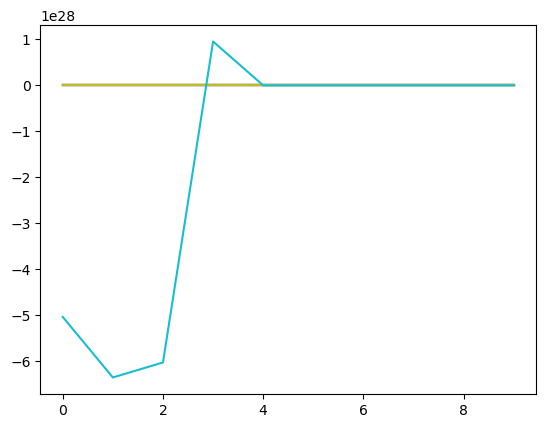

In [29]:
plt.plot(model_edmd.A)

In [26]:
Xkoop = model_edmd.simulate(state_controlled[np.newaxis,0,0,:], n_steps=4)

/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3/envs/m5r/lib/python3.11/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The attribute `n_input_features_` was deprecated in version 1.0 and will be removed in 1.2.
  warnings.warn(msg, category=FutureWarning)
/Users/shi/anaconda3